## 1. Introduction

In this project, I explored using deep learning-based method to detect facial key points and then categorize human faces into different styles empirically

## 2. Methods
In this section, I proposed a method to detect facial key points and then categorize the portrait image into different styles accordingly. The overall flowchart of the method is illustrated in the three main stages are (1) face detection using OpenCV, (2) face landmarks detection based on FCN, (3) style categorization based on face morphology calculated using detected facial key points

### 2.1 Face Recognition
The task of recognition is to detect whether a face exists in the image, and box the region of interest if there is a face. In this project, a detection method based on Haar feature-based cascade classifiers [1] is used. The features are calculated using all possible sizes and locations of each Haar convolutional kernel. In order to save computation time and resource, classifiers are cascade. For most of the image blocks that do not contain face information, the a few features are examined in the first few stages before achieving failure decisions.

In this project, I utilize the pre-trained cascade classifiers in OpenCV 

In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# Read the input image
img = cv2.imread('./data/test/00001.png')
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

### 2.2 Face Key Point Detection using DL model
Given the face region, I introduce a fixed detection stage based on the FCN to further detect facial key points. In this project, I crop the ROI that contains face to 96 by 96 pixels.
Here I use the Kaggle dataset for model training and evaluating. There are in total over 7000 training images. In this study, I only use the images with full lists of 15 annotated key points in Kaggle training folder.

In [ ]:
# load data
FTRAIN = './data/facial-keypoints-detection/training.csv'

X, Y = load(FTRAIN)
X = X.reshape(-1,96,96)
# split into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

### data augmentation 
In order to further enlarge the number of training images, and to increase the variety of face pattens, 2 data augmentation process is included: (1) random affine transform and (2) horizontal flip. In this section, I randomly generate a shift $(\Delta x, \Delta y)$ where $\Delta x, \Delta y$ are independent uniformly distributed between 0 and 5 pixels. Then each pixel in the transformed image is defined as
$$I_t (x,y)=I_0 (x+\Delta x,y+\Delta y)$$
where $I_0$ represents the intensity of original image at a specific location. Each pixel in the horizontal flipped image is defined as
$$I_f (x,y)=I_0 (96-x,y)$$
The raw image (left), affine translated image (center) and flipped image (right) are illustrated.
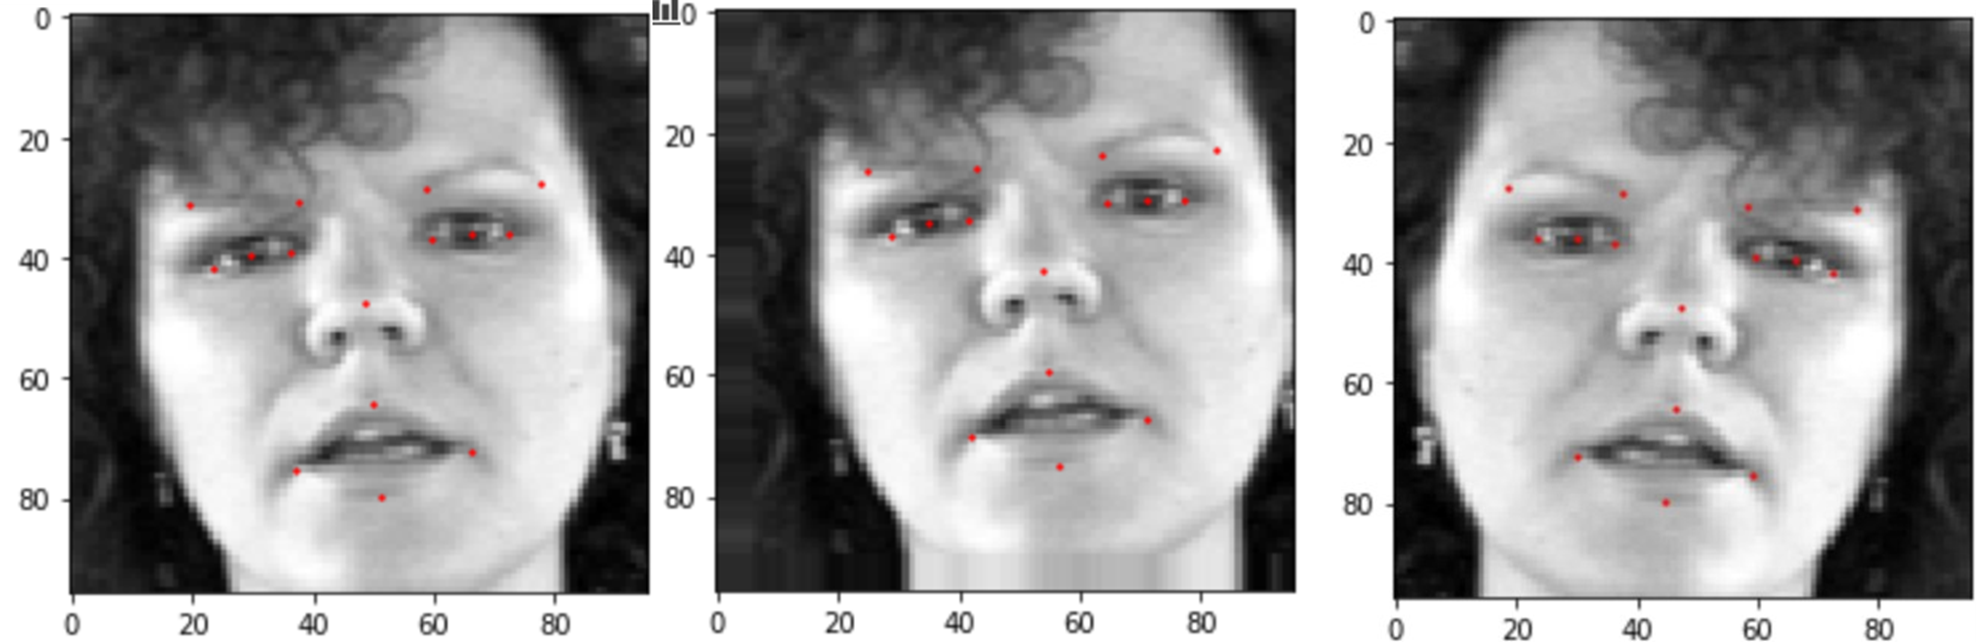

In [ ]:
def img_affine(x, y, dx, dy, width, height):
    xt = ndimage.shift(x, (dy, dx), mode='nearest')
    yt = np.zeros(30)
    for i in range(15):
        yt[2*i] = y[2*i] + dx / width
        yt[2*i+1] = y[2*i+1] + dy / height
    return xt, yt

def img_hflip(x, y):
    xf = np.fliplr(x)
    yf = np.zeros(30)
    for i in range(15):
        yf[2*i] = 1.0 - y[2*i]
        yf[2*i+1] = y[2*i+1]
    return xf, yf

### FCN model 
The fully connected network (FCN) has been well developed and widely used in the domain of sematic segmentation. Thus, the detection stage in our method is based on a simplified version of FCN-8, as shown below.

Architecture:
 * Conv2D: 64 Filters, 5x5, same padding, ReLU activation
 * Conv2D: 64 Filters, 5x5, same padding, ReLU activation
 * Max Pool 2x2, Stride 2
 * Conv2D: 128 Filters, 5x5, same padding, ReLU activation
 * Conv2D: 128 Filters, 5x5, same padding, ReLU activation
 * Max Pool 2x2, Stride 2
 * Conv2D: 512 Filters, 24x24, same padding, ReLU activation
 * Conv2D: 512 Filters, 1x1, same padding, ReLU activation
 * Conv2d Transpose: 15 filters of 4x4, stride 4x4
 
In this project, I use the mean squared error as losses.
$$MSE = \frac{1}{n} \sum_x(P_x-H_x )^2 $$
where $P$ is the predicted map and $𝐻$ is the mask heatmap.

I use the Adam optimizer with adaptive learning rate. The learning rate will be decreased according to the loss changes in training and validation loss.

In [ ]:
from func_FCN import FCN

y_train0 = get_y_as_heatmap(Y_train0, 96, 96, 5)
X_train, X_valid, y_train, y_valid = train_test_split(X_train0, y_train0, test_size=0.2, random_state=43)

model = FCN(96, 96, 64)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [EarlyStopping(patience=10, verbose=1),
             ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
             ModelCheckpoint('model-tgs-seg2.h5', verbose=1, save_best_only=True, save_weights_only=True)]
history = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks, validation_data=(X_valid, y_valid))

The training and validation loss are illustrated in the following. The history is truncated if it does not change for 10 epochs. The total number of epochs is around 50.
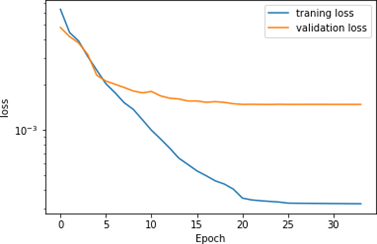

To extract the coordinate of predicted landmark from the heatmap, I calculate the weighted geometric center of largest n^2 pixels in the heatmap 
$$C_x = \sum_i P_i x_i, C_y = \sum_i P_i y_i$$
where $(x_i,y_i)$ indicates the pixel location of the $𝑖$-th largest pixel in the predicated heatmap, and its prediction value is $P_i$, i.e., $P_i=\max⁡ P_i$ for $i=1,2,…,n^2$



In [ ]:
def get_avg_xy(msk, n_points):
    h,w = msk.shape
    # 
    idx = np.argsort(msk, axis=None)
    idx = idx[-n_points:]
    hms = msk.flatten()[idx]
    x = idx % w
    y = np.floor(idx / h)
    cx = np.sum(x * hms) / np.sum(hms)
    cy = np.sum(y * hms) / np.sum(hms)

    return np.array([cy, cx]), msk[int(np.round(cy)), int(np.round(cx))]

The facial key points detected using the proposed FCN is illustrated in Figure as follow.
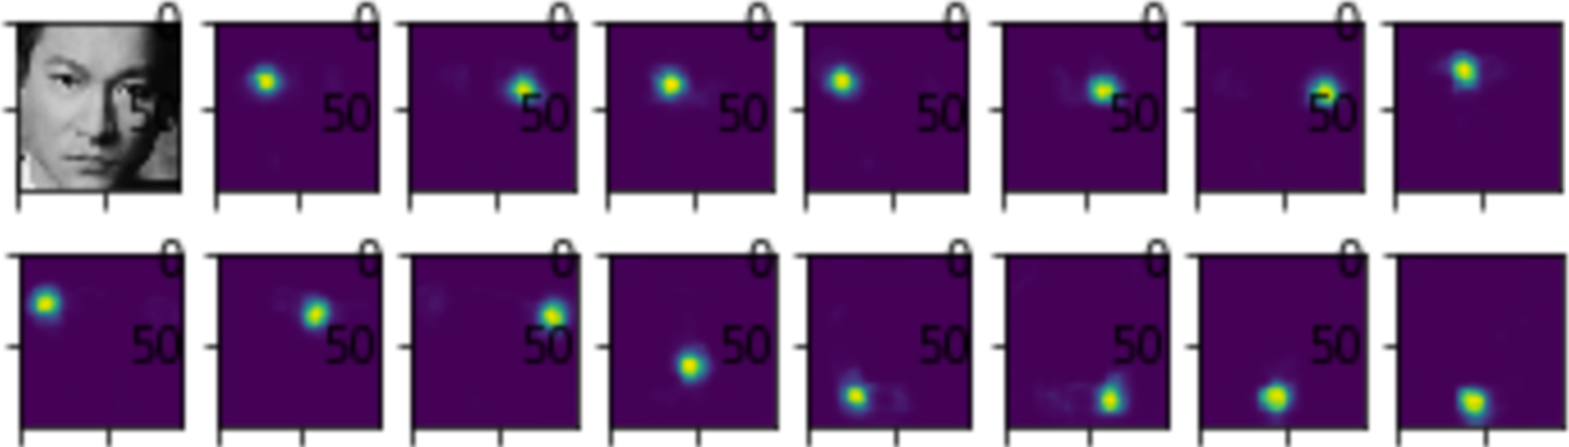

Besides, I also calculate the average distance between the predicted points and labeled points using the testing dataset. The average error among all 15 key points is 6.27 pixels. I also check the details of errors and find that the predicts of mouth lip center and nose tip are much accurate.

In [ ]:
# calculate average distance between predict and label points
distance = []
for i in range(15):
    distance.append(np.sqrt((loc_pred[:,2*i] - loc_label[:,2*i]) ** 2 + (loc_pred[:,2*i+1] - loc_label[:,2*i+1]) ** 2))
distance = np.array(distance)
avg_dist_per_loc = np.mean(distance, axis=1)
avg_dist = np.mean(avg_dist_per_loc)
print('average error distance among all 15 key points is %f\n'%(avg_dist))

### 2.3 Face categorize
In recent literatures, researchers have discovered the relationships between genetic, environmental and racial factors [4]. In this section, I simply classify the detect face into two categories: (1) Asian and (2) Western style. In this project, I simply calculate the following facial morphological information and group the subject accordingly. 
Right now, the thresholding is selected empirically, referencing to the publications [5]. In the future, I can prepare more face images with ethnical information, and learn those features from those images using the machine learning methods, such as decision trees.

## Conclusions, and future
In this project, firstly the human face is localized in a portrait. In the second stage, a deep learning-based facial key points detection model is developed. A gaussian kernel is applied to transform the difficult point detection problem to a segmentation problem. In the third stage, I proposed to classify the suitable styles for different human faces based on the knowledge in the field of social science.
In the future, I will further improve the landmarks detection by combining the first and second stage

## Reference

[1]. Viola, P., & Jones, M. (2001, December). Rapid object detection using a boosted cascade of simple features. In Proceedings of the 2001 IEEE computer society conference on computer vision and pattern recognition. CVPR 2001 (Vol. 1, pp. I-I). IEEE.

[2]. Bradski, G. (2000). The OpenCV Library. Dr. Dobb. Journal of Software Tools.

[3]. Yoshua B. (2016). Facial Key points Detection from https://www.kaggle.com/c/facial- keypoints-detection.

[4]. Tsagkrasoulis, D., Hysi, P., Spector, T., & Montana, G. (2017). Heritability maps of human face morphology through large-scale automated three-dimensional phenotyping. Scientific reports, 7, 45885.

[5]. Wen, Y. F., Wong, H. M., Lin, R., Yin, G., & McGrath, C. (2015). Inter-ethnic/racial facial variations: a systematic review and Bayesian meta-analysis of photogrammetric studies. PloS one, 10(8), e0134525.